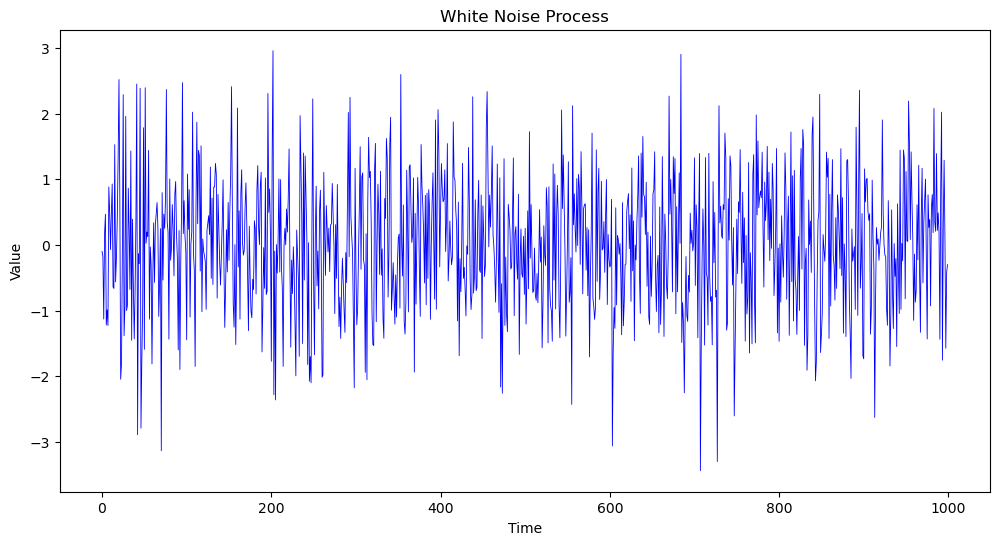

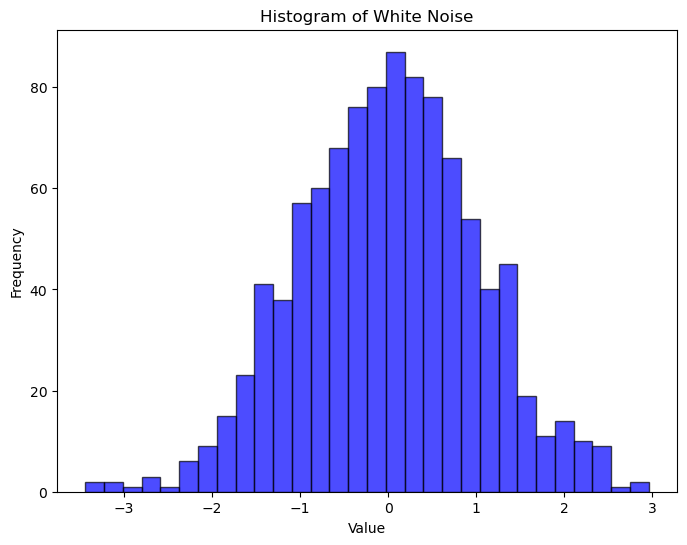

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
import multiprocessing as mp
from typing import Optional

# Constants
FIG_SIZE_LARGE = (12, 6)
FIG_SIZE_MEDIUM = (8, 6)

def generate_white_noise(n: int = 1000, mean: float = 0, std_dev: float = 1) -> np.ndarray:
    """
    Generate white noise series.

    Args:
        n: Number of data points.
        mean: Mean of the white noise.
        std_dev: Standard deviation of the white noise.

    Returns:
        Generated white noise series.

    Raises:
        ValueError: If number of data points is not positive or standard deviation is negative.
    """
    if n <= 0:
        raise ValueError("Number of data points must be positive")
    if std_dev < 0:
        raise ValueError("Standard deviation must be non-negative")
    return np.random.normal(mean, std_dev, n)

def plot_series(series: np.ndarray, title: str = 'Time Series', xlabel: str = 'Time', ylabel: str = 'Value', save_path: Optional[str] = None) -> None:
    """
    Plot a time series.

    Args:
        series: Time series data.
        title: Title of the plot.
        xlabel: X-axis label.
        ylabel: Y-axis label.
        save_path: Path to save the plot. If None, the plot is displayed.
    """
    plt.figure(figsize=FIG_SIZE_LARGE)
    plt.plot(series, color='blue', linewidth=0.6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_histogram(series: np.ndarray, bins: int = 30, title: str = 'Histogram', xlabel: str = 'Value', ylabel: str = 'Frequency', save_path: Optional[str] = None) -> None:
    """
    Plot a histogram of a series.

    Args:
        series: Data series.
        bins: Number of bins for the histogram.
        title: Title of the plot.
        xlabel: X-axis label.
        ylabel: Y-axis label.
        save_path: Path to save the plot. If None, the plot is displayed.
    """
    plt.figure(figsize=FIG_SIZE_MEDIUM)
    plt.hist(series, bins=bins, color='blue', edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def simulate_path(series):
    """
    Simulate a single path for the Monte Carlo simulation.

    Args:
        series: The input time series data.

    Returns:
        Simulated path.
    """
    return np.cumsum(np.random.choice(series, size=len(series)))

def monte_carlo_simulation(series: np.ndarray, num_simulations: int = 1000) -> np.ndarray:
    """
    Perform a Monte Carlo simulation on a time series.

    Args:
        series: Time series data.
        num_simulations: Number of simulations.

    Returns:
        Simulated series.

    Raises:
        ValueError: If number of simulations is not positive.
    """
    if num_simulations <= 0:
        raise ValueError("Number of simulations must be positive")
    
    with mp.Pool(processes=mp.cpu_count()) as pool:
        simulated_series = pool.starmap(simulate_path, [(series,)] * num_simulations)
    return np.array(simulated_series)

def plot_monte_carlo_simulation(simulated_series: np.ndarray, title: str = 'Monte Carlo Simulation', xlabel: str = 'Time', ylabel: str = 'Value', save_path: Optional[str] = None) -> None:
    """
    Plot the results of Monte Carlo simulations.

    Args:
        simulated_series: Simulated series data.
        title: Title of the plot.
        xlabel: X-axis label.
        ylabel: Y-axis label.
        save_path: Path to save the plot. If None, the plot is displayed.
    """
    plt.figure(figsize=FIG_SIZE_LARGE)
    for simulation in simulated_series:
        plt.plot(simulation, color='blue', linewidth=0.6, alpha=0.1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def print_statistics(stats: dict) -> None:
    """
    Print statistical measures in a formatted way.

    Args:
        stats: Dictionary containing statistical measures.
    """
    print("Statistical Summary:")
    print("-" * 20)
    for key, value in stats.items():
        print(f"{key:15}: {value:10.4f}")
    print("-" * 20)

def main(n: int = 1000, mean: float = 0, std_dev: float = 1, num_simulations: int = 1000, output_dir: Optional[str] = None, random_seed: Optional[int] = None) -> None:
    """
    Main function to perform white noise analysis and Monte Carlo simulation.

    Args:
        n: Number of data points.
        mean: Mean of white noise.
        std_dev: Standard deviation of white noise.
        num_simulations: Number of Monte Carlo simulations.
        output_dir: Directory to save output files.
        random_seed: Random seed for reproducibility.
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    try:
        white_noise = generate_white_noise(n, mean, std_dev)
        
        plot_series(white_noise, title='White Noise Process', save_path=f"{output_dir}/white_noise.png" if output_dir else None)
        plot_histogram(white_noise, title='Histogram of White Noise', save_path=f"{output_dir}/histogram.png" if output_dir else None)
        
        simulated_series = monte_carlo_simulation(white_noise, num_simulations)
        plot_monte_carlo_simulation(simulated_series, title='Monte Carlo Simulation of White Noise', save_path=f"{output_dir}/monte_carlo_simulation.png" if output_dir else None)
        
        calculated_mean = np.mean(white_noise)
        calculated_variance = np.var(white_noise)
        calculated_skewness = stats.skew(white_noise)
        calculated_kurtosis = stats.kurtosis(white_noise)
        autocorrelation = np.correlate(white_noise, white_noise, mode='full')[len(white_noise)-1:]
        
        statistics = {
            "Mean": calculated_mean,
            "Variance": calculated_variance,
            "Skewness": calculated_skewness,
            "Kurtosis": calculated_kurtosis,
            "Autocorrelation at lag 1": autocorrelation[1]
        }
        print_statistics(statistics)
        
    except ValueError as ve:
        print(f"Value Error: {ve}. Please check your input parameters.")
    except TypeError as te:
        print(f"Type Error: {te}. Please ensure all inputs are of the correct type.")
    except MemoryError:
        print("Memory Error: Not enough memory to complete the operation. Try reducing the number of simulations or data points.")
    except IOError as io:
        print(f"I/O Error: {io}. There was a problem reading or writing files.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

if __name__ == "__main__":
    if 'ipykernel' in sys.modules:
        main()
    else:
        import argparse
        parser = argparse.ArgumentParser(description="Analyze white noise time series with Monte Carlo simulation.")
        parser.add_argument("--n", type=int, default=1000, help="Number of data points")
        parser.add_argument("--mean", type=float, default=0, help="Mean of white noise")
        parser.add_argument("--std_dev", type=float, default=1, help="Standard deviation of white noise")
        parser.add_argument("--num_simulations", type=int, default=1000, help="Number of Monte Carlo simulations")
        parser.add_argument("--output_dir", type=str, help="Directory to save output files")
        parser.add_argument("--random_seed", type=int, help="Random seed for reproducibility")
        args = parser.parse_args()
        
        main(args.n, args.mean, args.std_dev, args.num_simulations, args.output_dir, args.random_seed)
